In [195]:
from yolact import Yolact
from data import cfg, set_cfg
from utils.augmentations import FastBaseTransform
from layers.output_utils import postprocess

import torch
import torch.backends.cudnn as cudnn
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import time

In [2]:
def evalframe(net, frame):
    batch = FastBaseTransform()(frame.unsqueeze(0))
    preds = net(batch)

    return preds

In [81]:
set_cfg('yolact_plus_resnet50_config')  # Set config
torch.set_default_tensor_type('torch.cuda.FloatTensor')  # Setup pytorch cuda
cudnn.fastest = True
dataset = None  # Set dataset none

net = Yolact()
net.load_weights('weights/yolact_plus_resnet50_112_28800.pth')
net.eval()  # set to evaluation mode
net.cuda()  # use cuda

net.detect.use_fast_nms = True
net.detect.use_cross_class_nms = False
cfg.mask_proto_debug = False





In [257]:
path = '../images_00/0891.png' #791 has connected region example
image = cv2.imread(path)
h, w, _ = image.shape
frame = torch.from_numpy(image).cuda().float()
classes, scores, boxes, masks = postprocess(evalframe(net, frame), w, h, score_threshold=0.5)

print(masks[0][0])


tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SelectBackward>)


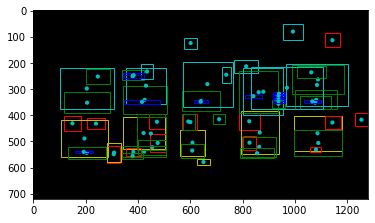

In [317]:
def class_color(x):
    colours = ['r', 'g', 'b', 'c', 'y', 'm', 'orangered', 'olivedrab', 'purple', 'slategrey']
    return colours[x%(len(colours))]

fig, ax = plt.subplots()
whitespace = np.full((h, w, 3), 255, dtype='uint8')
#ax.imshow(whitespace)
ax.imshow(np.array(Image.open(path)))

boxes = boxes.cpu()
classes = classes.cpu()
masks = masks.cpu()

detections = []
for i in range(0,boxes.shape[0]):
    box = boxes[i]
    det = {'box' : box,
           'box_centre' : ((box[0] + box[2])/2, (box[1]+box[3])/2),
           'mask' : masks[i]}
    detections.append(det)


def bgramask(mask, b, g, r, a):
    rch = mask
    rch[rch==255] = r
    gch = mask
    gch[gch==255] = g
    bch = mask
    bch[bch==255] = b
    ach = mask
    
    return np.stack((bch, gch, rch), axis=2)

testmask = masks[0].detach().numpy()
testmask = bgramask(testmask, 255, 128, 0, 0.5)
ax.imshow(testmask)

for i in range(boxes.shape[0]):
    box = boxes[i]
    col = class_color(classes[i])
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor=col, facecolor='none')
    point = patches.Circle(((box[0]+box[2])/2, (box[1]+box[3])/2),8, facecolor='c')
    ax.add_patch(rect)
    ax.add_patch(point)



[   251    201    955    420 180600]
[     0      0   1280    720 535427]
[ 1017   215   162   163 26073]
[  571   222   154   159 24366]
[  351   227   156   166 25783]
[  797   226   162   153 24472]
[ 1017   392   168   166 27385]
[  571   399   154   161 24708]
[  801   398   163   163 26366]
[  343   401   161   165 26420]


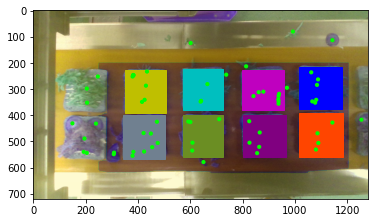

In [290]:
#Thresholding to remove blue belt BG
upperBlue = np.array([230, 130, 60])
lowerBlue = np.array([50, 25, 0])
mask = cv2.inRange(image, lowerBlue, upperBlue)

#Mask out edges of image
def maskEdges(img, top, bottom, left, right):
    img[0:top] = 0 #Top margin
    img[-bottom:] = 0 #Bottom margin
    img[:, 0:left] = 0 #Left margin
    img[:, -right:] = 0 #Right Margin
    return img
mask = maskEdges(mask, 200, 100, 250, 75)

#Closing on image to extract sandwich regions
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(120,120))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

#Connected Components
mask = cv2.bitwise_not(mask)
numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, 4)
for i in stats:
    print(i)
    
#Show result

fig, ax = plt.subplots()
ax.imshow(mask, alpha=0.2)



for i in range(2, numLabels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    rect = patches.Rectangle((x,y), w, h, linewidth=1, edgecolor=class_color(i), facecolor=class_color(i))
    ax.add_patch(rect)
for i in range(boxes.shape[0]):
    box = boxes[i]
    col = class_color(classes[i])
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor=col, facecolor='none')
    point = patches.Circle(((box[0]+box[2])/2, (box[1]+box[3])/2),8, facecolor='lime')
    #ax.add_patch(rect)
    ax.add_patch(point)